### Imports

In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob

import matplotlib.pyplot as plt
%matplotlib inline

import zipfile

import os
import re
from glob import glob
import time
import random
import numpy as np
import pandas as pd
import torch

import torch.nn.functional as F
import torchmetrics
from torchmetrics.classification import MulticlassMatthewsCorrCoef
import open3d as o3
# from open3d import JVisualizer # For Colab Visualization
from open3d.web_visualizer import draw # for non Colab



import torch.optim as optim

from sklearn.metrics import confusion_matrix
from random import randrange

from sklearn import metrics




Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [2]:
runs_on = "Local" # or "Local" for testing purposes

### Downloading Dataset

Dataset: Sorghum Plants Labeled 3D LiDAR Point Cloud Data

Located at: https://data.mendeley.com/datasets/pfnfzrmrg7/1


### Loading the dataset

In [3]:
if runs_on == "Colab":
  from google.colab import drive
  drive.mount('/content/drive')

**SET the folder the zip file is stored**

In [ ]:

if runs_on == "Colab": 
  data_dir = "/content/drive/My Drive/PointNet-Keras/Data/"
  models_dir = "/content/drive/My Drive/PointNet-Keras/models/"
  zipfilename = "Sorghum Plants Labeled 3D LiDAR Point Cloud Data.zip"
else: 
  data_dir = "C:\\Users\\nydor_pt\\MY-DOCUMENTS\\JIMMY\\UCD\\Jimmy-PHD\\Papers-Read\\3D PointCloud Datasets\\Sorghum_Plants\\"
  #zipfilename = "dataset_short_25.zip"
  zipfilename = "Sorghum Plants Labeled 3D LiDAR Point Cloud Data.zip"
 



Set some settings!!!

In [ ]:
npoints = 1000
# When in full dataset then batch_size = 32
# else batch_size = 8 !!!!!
batch_size = 32 # 8
epochs = 2 # 100
modelname = "testing"

Num of total samples = 502

20% split (training / validation)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

categories = ["leaf", "stem", "panice"]
num_classes = len(categories)
features_used = 'xyz' #'xyzrgb'
valid_split = 0.2
'''
if runs_on == "Colab":
    #n_train_samples = 490
else:
    #n_train_samples = 20 # 490 # 20
'''

Device:  cuda


'\nif runs_on == "Colab":\n    #n_train_samples = 490\nelse:\n    #n_train_samples = 20 # 490 # 20\n'

## Structuring the dataset


In [7]:
def pc_normalize(pc):
    c = np.mean(pc, axis=0)
    pc = pc - c
    m = np.max(np.sqrt(np.sum(pc ** 2, axis=1)))
    pc = pc /m
    return pc

In [8]:
t_pointclouds = []
t_pointclouds_labels = []
test_pointclouds_labels = []
test_pointclouds = []
#t_pointclouds_cls = []
#test_pointclouds_cls = []

minpoints = 50000000

zf = zipfile.ZipFile(data_dir + zipfilename)
points_files = zf.infolist()

print ("Uncompressing and reading data... ")
i=1
for point_file in tqdm(points_files):
    #print(point_file.filename)

    if point_file.filename == "dataset_short/": 
        continue
    df = pd.read_csv(zf.open(point_file.filename), sep=" ", header=None)
    try:
        df.columns = ["x", "y", "z", "r", "g", "b", "l1", "l2"]
    except Exception as e: 
        # labeled_plant137.txt: has 9 columns. the last colmn has nan values
        #print("Cleaning the Exception for: \n")
        #print("File: ", point_file)
        #print(df.shape)  
        df = df.iloc[:,:-1] 
        df.columns = ["x", "y", "z", "r", "g", "b", "l1", "l2"]
        #print(e)
        
    #print(df.shape)
    if (df.shape[0]<minpoints):
        minpoints = df.shape[0]
    df['label1'] = np.where(df['l1'] == 0, 'leaf', np.where(df['l1'] == 1, 'stem', 'panice')) 
    df['cls'] = 0
    
    if 'rgb' in features_used:
        pointcloud = df[["x", "y", "z", "r", "g", "b"]]
    else: 
        pointcloud = df[["x", "y", "z"]]
    
    pointcloud_labels = df['l1'].tolist()
    pointcloud_cls = df['cls'].tolist()

    # Randomly sampling respective indices.
    choice = np.random.choice(len(pointcloud_labels), npoints, replace = True)
    # Resampling points corresponding to sampled indices.
    sampled_pointcloud = pointcloud.to_numpy()[choice, :]
    #sampled_pointcloud_labels = pointcloud_labels[choice]
    sampled_pointcloud_labels = np.array([pointcloud_labels[i] for i in choice])
    #sampled_pointcloud_cls = np.array([pointcloud_cls[i] for i in choice])

    # Normalize 
    norm_pointcloud = pc_normalize(sampled_pointcloud)
    '''
    if i <= n_train_samples:
        t_pointclouds.append(norm_pointcloud)
        t_pointclouds_labels.append(sampled_pointcloud_labels)
        #t_pointclouds_cls.append(sampled_pointcloud_cls)

    else:
        test_pointclouds.append(norm_pointcloud)
        test_pointclouds_labels.append(sampled_pointcloud_labels)
        #test_pointclouds_cls.append(sampled_pointcloud_cls)
    '''
    t_pointclouds.append(norm_pointcloud)
    t_pointclouds_labels.append(sampled_pointcloud_labels)
    i = i + 1
    '''
    if i>5:
        break'
    '''
 



Uncompressing and reading data... 


100%|██████████| 26/26 [00:05<00:00,  4.70it/s]


In [9]:
# print minimum number of points in the samples
print(minpoints)

87293


In [10]:
print(len(t_pointclouds))
print(t_pointclouds[0].shape)
print(type(t_pointclouds[2]))

print(len(t_pointclouds_labels[0]))
print(len(t_pointclouds_labels))
print(type(t_pointclouds_labels))

'''
print(len(test_pointclouds))
print(test_pointclouds[0].shape)
print(type(test_pointclouds[2]))

print(len(test_pointclouds_labels[0]))
print(len(test_pointclouds_labels))
print(type(test_pointclouds_labels))
'''



25
(1000, 3)
<class 'numpy.ndarray'>
1000
25
<class 'list'>


'\nprint(len(test_pointclouds))\nprint(test_pointclouds[0].shape)\nprint(type(test_pointclouds[2]))\n\nprint(len(test_pointclouds_labels[0]))\nprint(len(test_pointclouds_labels))\nprint(type(test_pointclouds_labels))\n'

In [11]:
# split to training and validation pointclouds
split_index = int(len(t_pointclouds) * (1 - valid_split))
train_pointclouds = t_pointclouds[:split_index]
train_pointclouds_labels = t_pointclouds_labels[:split_index]
#train_pointclouds_cls = t_pointclouds_cls[:split_index]

valid_pointclouds = t_pointclouds[split_index:]
valid_pointclouds_labels = t_pointclouds_labels[split_index:]
#valid_pointclouds_cls = t_pointclouds_cls[split_index:]

print("Num train point clouds:", len(train_pointclouds))
print("Num train point cloud labels:", len(train_pointclouds_labels))
print("Num validation point clouds:", len(valid_pointclouds))
print("Num validation point cloud labels:", len(valid_pointclouds_labels))
'''
print("Num test point clouds:", len(test_pointclouds))
print("Num test point cloud labels:", len(test_pointclouds_labels))
'''

Num train point clouds: 20
Num train point cloud labels: 20
Num validation point clouds: 5
Num validation point cloud labels: 5


'\nprint("Num test point clouds:", len(test_pointclouds))\nprint("Num test point cloud labels:", len(test_pointclouds_labels))\n'

### Visualize some data

In [12]:
def read_pointnet_colors(seg_labels):
    map_label_to_rgb = {
        0: [0, 0, 255], # blue
        1: [0, 128, 0], # green
        2: [255, 0, 0], # red
    }
    colors = np.array([map_label_to_rgb[label] for label in seg_labels])
    return colors

In [13]:
def visualize_data(pointcloud,pointcloud_labels):

    pcd = o3.geometry.PointCloud()
    pcd.points = o3.utility.Vector3dVector(pointcloud)
    pcd.colors = o3.utility.Vector3dVector(read_pointnet_colors(np.asarray(pointcloud_labels, dtype=np.float32)))

    o3.visualization.draw_plotly([pcd])

    # optional visualization for non Colab
    # draw(pcd)

In [14]:
idx = 5
visualize_data(train_pointclouds[idx],train_pointclouds_labels[idx])

Save data to a ply file

In [15]:
# setup dataloaders
kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.from_numpy(np.asarray(train_pointclouds, dtype=np.float32)), 
                                   #torch.from_numpy(np.asarray(train_pointclouds_cls, dtype=np.float32)).type(torch.LongTensor),
                                   torch.from_numpy(np.asarray(train_pointclouds_labels, dtype=np.float32)).type(torch.LongTensor)), 
    shuffle=True,
    batch_size=batch_size,
    **kwargs
)

kwargs = {'num_workers': 1, 'pin_memory': True}
valid_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.from_numpy(np.asarray(valid_pointclouds, dtype=np.float32)), 
                                   #torch.from_numpy(np.asarray(valid_pointclouds_cls, dtype=np.float32)).type(torch.LongTensor),
                                   torch.from_numpy(np.asarray(valid_pointclouds_labels, dtype=np.float32)).type(torch.LongTensor)), 
    shuffle=True,
    batch_size=batch_size,
    **kwargs
)
'''
kwargs = {'num_workers': 1, 'pin_memory': True}
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.from_numpy(np.asarray(test_pointclouds, dtype=np.float32)), 
                                   #torch.from_numpy(np.asarray(test_pointclouds_cls, dtype=np.float32)).type(torch.LongTensor),
                                   torch.from_numpy(np.asarray(test_pointclouds_labels, dtype=np.float32)).type(torch.LongTensor)), 
    shuffle=True,
    batch_size=batch_size,
    **kwargs
)
'''

print("Num train dataloader length:", len(train_loader.dataset))
print("Num valid dataloader length:", len(valid_loader.dataset))
#print("Num test dataloader length:", len(test_loader.dataset))

Num train dataloader length: 20
Num valid dataloader length: 5


# PointNet++

In [16]:
model_name = "pointnet2_part_seg_msg" # or pointnet_part_seg

In [17]:
def inplace_relu(m):
    classname = m.__class__.__name__
    if classname.find('ReLU') != -1:
        m.inplace=True

def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    new_y = torch.eye(num_classes)[y.cpu().data.numpy(),]
    if (y.is_cuda):
        return new_y.cuda()
    return new_y

In [18]:
seg_classes = {'Plant': [0, 1, 2]}
seg_label_to_cat = {}  # {0:Plant, 1:Plant, 2:Plant}
for cat in seg_classes.keys():
    for label in seg_classes[cat]:
        seg_label_to_cat[label] = cat
print(seg_classes)
print(seg_label_to_cat)

{'Plant': [0, 1, 2]}
{0: 'Plant', 1: 'Plant', 2: 'Plant'}


In [19]:
num_classes = 1     # only Plant
num_part = 3        # 0, 1, 2

In [20]:

import datetime
from pathlib import Path
import sys

BASE_DIR = os.path.abspath('')
ROOT_DIR = BASE_DIR
sys.path.append(os.path.join(ROOT_DIR, 'models'))

'''CREATE DIR'''
log_dir = "skatoulesXXX"
timestr = str(datetime.datetime.now().strftime('%Y-%m-%d_%H-%M'))
exp_dir = Path('./log/')
exp_dir.mkdir(exist_ok=True)
exp_dir = exp_dir.joinpath('part_seg')
exp_dir.mkdir(exist_ok=True)

exp_dir = exp_dir.joinpath(log_dir)
exp_dir.mkdir(exist_ok=True)
checkpoints_dir = exp_dir.joinpath('checkpoints/')
checkpoints_dir.mkdir(exist_ok=True)
log_dir = exp_dir.joinpath('logs/')
log_dir.mkdir(exist_ok=True)

In [21]:
def log_string(str):
    logger.info(str)
    print(str)

In [22]:
import logging

logger = logging.getLogger("Model")
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler = logging.FileHandler('%s/%s.txt' % (log_dir, model_name))
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)
#log_string('PARAMETER ...')

In [23]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        torch.nn.init.xavier_normal_(m.weight.data)
        torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find('Linear') != -1:
        torch.nn.init.xavier_normal_(m.weight.data)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [24]:
import importlib
import shutil

'''MODEL LOADING'''
model_name = "pointnet2_part_seg_msg" # or pointnet_part_seg
MODEL = importlib.import_module(model_name)
shutil.copy('models/%s.py' % model_name, str(exp_dir))
shutil.copy('models/pointnet2_utils.py', str(exp_dir))
normal_channel = False
classifier = MODEL.get_model(num_part, normal_channel=normal_channel).cuda()
# negative log likelihood loss
criterion = MODEL.get_loss().cuda()
classifier.apply(inplace_relu)

get_model(
  (sa1): PointNetSetAbstractionMsg(
    (conv_blocks): ModuleList(
      (0): ModuleList(
        (0): Conv2d(6, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
        (2): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): ModuleList(
        (0): Conv2d(6, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      )
      (2): ModuleList(
        (0): Conv2d(6, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1))
        (2): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (bn_blocks): ModuleList(
      (0): ModuleList(
        (0-1): 2 x BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
     

In [25]:
exp_dir

WindowsPath('log/part_seg/skatoulesXXX')

In [26]:
try:
    checkpoint = torch.load(str(exp_dir) + '/checkpoints/best_model.pth')
    start_epoch = checkpoint['epoch']
    classifier.load_state_dict(checkpoint['model_state_dict'])
    log_string('Use pretrain model')
except:
    log_string('No existing model, starting training from scratch...')
    start_epoch = 0
    classifier = classifier.apply(weights_init)

No existing model, starting training from scratch...


In [27]:
optimizer_name = "Adam"
learning_rate = 0.001
decay_rate = 1e-4
if optimizer_name == 'Adam':
    optimizer = torch.optim.Adam(
        classifier.parameters(),
        lr=learning_rate,
        betas=(0.9, 0.999),
        eps=1e-08,
        weight_decay=decay_rate
    )
else:
    optimizer = torch.optim.SGD(classifier.parameters(), lr=learning_rate, momentum=0.9)

mcc_metric = MulticlassMatthewsCorrCoef(num_classes=num_part).to(device)

In [28]:
def bn_momentum_adjust(m, momentum):
    if isinstance(m, torch.nn.BatchNorm2d) or isinstance(m, torch.nn.BatchNorm1d):
        m.momentum = momentum

In [29]:
def compute_iou(targets, predictions):

    targets = targets.reshape(-1)
    predictions = predictions.reshape(-1)

    intersection = torch.sum(predictions == targets) # true positives
    union = len(predictions) + len(targets) - intersection

    return intersection / union 

In [30]:
import provider

In [31]:
LEARNING_RATE_CLIP = 1e-5
MOMENTUM_ORIGINAL = 0.1
MOMENTUM_DECCAY = 0.5
step_size = 20
MOMENTUM_DECCAY_STEP = step_size

best_acc = 0
global_epoch = 0
best_class_avg_iou = 0
best_inctance_avg_iou = 0

lr_decay = 0.5

train_loss = []
train_accuracy = []
train_mcc = []
train_iou = []
valid_losses = []
valid_accuracy = []
valid_mccs = []
valid_ious = []



for epoch in range(start_epoch, epochs):
    mean_correct = []
    _train_loss = []
    _train_mcc = []
    _train_iou = []

    log_string('Epoch %d (%d/%s):' % (global_epoch + 1, epoch + 1, epochs))
    '''Adjust learning rate and BN momentum'''
    lr = max(learning_rate * (lr_decay ** (epoch // step_size)), LEARNING_RATE_CLIP)
    log_string('Learning rate:%f' % lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    momentum = MOMENTUM_ORIGINAL * (MOMENTUM_DECCAY ** (epoch // MOMENTUM_DECCAY_STEP))
    if momentum < 0.01:
        momentum = 0.01
    print('BN momentum updated to: %f' % momentum)
    classifier = classifier.apply(lambda x: bn_momentum_adjust(x, momentum))
    classifier = classifier.train()

    '''learning one epoch'''
    for i, (points, target) in tqdm(enumerate(train_loader), total=len(train_loader), smoothing=0.9):
        optimizer.zero_grad()

        points = points.data.numpy()
        points[:, :, 0:3] = provider.random_scale_point_cloud(points[:, :, 0:3])
        points[:, :, 0:3] = provider.shift_point_cloud(points[:, :, 0:3])
        points = torch.Tensor(points)
        points, target = points.float().cuda(), target.long().cuda()
        points = points.transpose(2, 1)


        seg_pred, trans_feat = classifier(points)
        seg_pred = seg_pred.contiguous().view(-1, num_part)
        target = target.view(-1, 1)[:, 0]
        pred_choice = seg_pred.data.max(1)[1]

        correct = pred_choice.eq(target.data).cpu().sum()
        mean_correct.append(correct.item() / (batch_size * npoints))
        #print("TRAIN LOSS: ", seg_pred.shape, target.shape, trans_feat.shape)
        loss = criterion(seg_pred, target, trans_feat)
        loss.backward()
        optimizer.step()

        # get metrics
        mcc = mcc_metric(seg_pred, target)
        iou = compute_iou(target, pred_choice)

        # update epoch loss and accuracy
        _train_loss.append(loss.item())
        #_train_accuracy.append(accuracy)
        _train_mcc.append(mcc.item())
        _train_iou.append(iou.item())


    train_instance_acc = np.mean(mean_correct)

    train_loss.append(np.mean(_train_loss))
    train_accuracy.append(train_instance_acc)
    train_mcc.append(np.mean(_train_mcc))
    train_iou.append(np.mean(_train_iou))

    print(f'Epoch: {epoch} - Train Loss: {np.mean(_train_loss):.4f} ' \
        + f'- Train Accuracy: {train_instance_acc:.4f} ' \
        + f'- Train MCC: {np.mean(_train_mcc):.4f} ' \
        + f'- Train IOU: {np.mean(_train_iou):.4f}')
    

    log_string('-------------------------------------------------')

    with torch.no_grad():
        test_metrics = {}
        total_correct = 0
        total_seen = 0
        total_seen_class = [0 for _ in range(num_part)]
        total_correct_class = [0 for _ in range(num_part)]
        shape_ious = {cat: [] for cat in seg_classes.keys()}
        seg_label_to_cat = {}  # {0:Airplane, 1:Airplane, ...49:Table}

        for cat in seg_classes.keys():
            for label in seg_classes[cat]:
                seg_label_to_cat[label] = cat

        classifier = classifier.eval()

        _valid_loss = []
        _valid_mcc = []
        _valid_iou = []

        for batch_id, (points, target) in tqdm(enumerate(valid_loader), total=len(valid_loader), smoothing=0.9):
            cur_batch_size, NUM_POINT, _ = points.size()
            points, target = points.float().cuda(), target.long().cuda()
            points = points.transpose(2, 1)
            seg_pred, trans_feat = classifier(points)

            # get metrics
            valid_loss = criterion(seg_pred.contiguous().view(-1, num_part), target.view(-1, 1)[:, 0], trans_feat) 

            #print("VALID LOSS: ", seg_pred.contiguous().view(-1, num_part).shape, target.view(-1, 1)[:, 0].shape, trans_feat.shape)
            valid_mcc = mcc_metric(seg_pred.contiguous().view(-1, num_part), target.view(-1, 1)[:, 0])
            val_pred_choice = torch.softmax(seg_pred, dim=2).argmax(dim=2)
            valid_iou = compute_iou(target, val_pred_choice)


            cur_pred_val = seg_pred.cpu().data.numpy()
            cur_pred_val_logits = cur_pred_val
            cur_pred_val = np.zeros((cur_batch_size, NUM_POINT)).astype(np.int32)
            target = target.cpu().data.numpy()

            

            for i in range(cur_batch_size):
                cat = seg_label_to_cat[target[i, 0]]
                logits = cur_pred_val_logits[i, :, :]
                cur_pred_val[i, :] = np.argmax(logits[:, seg_classes[cat]], 1) + seg_classes[cat][0]

            correct = np.sum(cur_pred_val == target)
            total_correct += correct
            total_seen += (cur_batch_size * NUM_POINT)

            for l in range(num_part):
                total_seen_class[l] += np.sum(target == l)
                total_correct_class[l] += (np.sum((cur_pred_val == l) & (target == l)))

            for i in range(cur_batch_size):
                segp = cur_pred_val[i, :]
                segl = target[i, :]
                cat = seg_label_to_cat[segl[0]]
                part_ious = [0.0 for _ in range(len(seg_classes[cat]))]
                for l in seg_classes[cat]:
                    if (np.sum(segl == l) == 0) and (
                            np.sum(segp == l) == 0):  # part is not present, no prediction as well
                        part_ious[l - seg_classes[cat][0]] = 1.0
                    else:
                        part_ious[l - seg_classes[cat][0]] = np.sum((segl == l) & (segp == l)) / float(
                            np.sum((segl == l) | (segp == l)))
                shape_ious[cat].append(np.mean(part_ious))
            
            # update epoch metrics
            _valid_loss.append(valid_loss.item())
            _valid_mcc.append(valid_mcc.item())
            _valid_iou.append(valid_iou.item())

        all_shape_ious = []
        for cat in shape_ious.keys():
            for iou in shape_ious[cat]:
                all_shape_ious.append(iou)
            shape_ious[cat] = np.mean(shape_ious[cat])
        mean_shape_ious = np.mean(list(shape_ious.values()))
        test_metrics['accuracy'] = total_correct / float(total_seen)

        for cat in sorted(shape_ious.keys()):
            log_string('eval mIoU of %s %f' % (cat + ' ' * (14 - len(cat)), shape_ious[cat]))
        test_metrics['class_avg_iou'] = mean_shape_ious
        test_metrics['inctance_avg_iou'] = np.mean(all_shape_ious)

    valid_losses.append(np.mean(_valid_loss))
    valid_accuracy.append(test_metrics['accuracy'])
    valid_mccs.append(np.mean(_valid_mcc))
    valid_ious.append(np.mean(_valid_iou))

    print(f'Epoch: {epoch} - Valid Loss: {valid_losses[-1]:.4f} ' \
            + f'- Valid Accuracy: {valid_accuracy[-1]:.4f} ' \
            + f'- Valid MCC: {valid_mccs[-1]:.4f} ' \
            + f'- Valid IOU: {valid_ious[-1]:.4f}')

    log_string('Epoch %d test Accuracy: %f  Class avg mIOU: %f   Inctance avg mIOU: %f' % (
        epoch + 1, test_metrics['accuracy'], test_metrics['class_avg_iou'], test_metrics['inctance_avg_iou']))
    if (test_metrics['inctance_avg_iou'] >= best_inctance_avg_iou):
        logger.info('Save model...')
        savepath = str(checkpoints_dir) + '/best_model.pth'
        log_string('Saving at %s' % savepath)
        state = {
            'epoch': epoch,
            'train_acc': train_instance_acc,
            'test_acc': test_metrics['accuracy'],
            'class_avg_iou': test_metrics['class_avg_iou'],
            'inctance_avg_iou': test_metrics['inctance_avg_iou'],
            'model_state_dict': classifier.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }
        torch.save(state, savepath)
        torch.save(classifier.state_dict(), f'trained_models/{modelname}.pth')
        log_string('Saving model....')

    if test_metrics['accuracy'] > best_acc:
        best_acc = test_metrics['accuracy']
    if test_metrics['class_avg_iou'] > best_class_avg_iou:
        best_class_avg_iou = test_metrics['class_avg_iou']
    if test_metrics['inctance_avg_iou'] > best_inctance_avg_iou:
        best_inctance_avg_iou = test_metrics['inctance_avg_iou']
    log_string('Best accuracy is: %.5f' % best_acc)
    log_string('Best class avg mIOU is: %.5f' % best_class_avg_iou)
    log_string('Best inctance avg mIOU is: %.5f' % best_inctance_avg_iou)
    global_epoch += 1


Epoch 1 (1/2):
Learning rate:0.001000
BN momentum updated to: 0.100000


100%|██████████| 3/3 [00:10<00:00,  3.34s/it]


Epoch: 0 - Train Loss: 0.9011 - Train Accuracy: 0.4740 - Train MCC: 0.2673 - Train IOU: 0.4250
-------------------------------------------------


100%|██████████| 1/1 [00:05<00:00,  5.13s/it]


eval mIoU of Plant          0.215267
Epoch: 0 - Valid Loss: 1.0442 - Valid Accuracy: 0.6458 - Valid MCC: 0.0000 - Valid IOU: 0.4769
Epoch 1 test Accuracy: 0.645800  Class avg mIOU: 0.215267   Inctance avg mIOU: 0.215267
Saving at log\part_seg\skatoulesXXX\checkpoints/best_model.pth
Saving model....
Best accuracy is: 0.64580
Best class avg mIOU is: 0.21527
Best inctance avg mIOU is: 0.21527
Epoch 2 (2/2):
Learning rate:0.001000
BN momentum updated to: 0.100000


100%|██████████| 3/3 [00:06<00:00,  2.23s/it]


Epoch: 1 - Train Loss: 0.6381 - Train Accuracy: 0.6483 - Train MCC: 0.5625 - Train IOU: 0.6456
-------------------------------------------------


100%|██████████| 1/1 [00:04<00:00,  4.89s/it]

eval mIoU of Plant          0.215267
Epoch: 1 - Valid Loss: 1.0164 - Valid Accuracy: 0.6458 - Valid MCC: 0.0000 - Valid IOU: 0.4769
Epoch 2 test Accuracy: 0.645800  Class avg mIOU: 0.215267   Inctance avg mIOU: 0.215267
Saving at log\part_seg\skatoulesXXX\checkpoints/best_model.pth
Saving model....
Best accuracy is: 0.64580
Best class avg mIOU is: 0.21527
Best inctance avg mIOU is: 0.21527


Plot

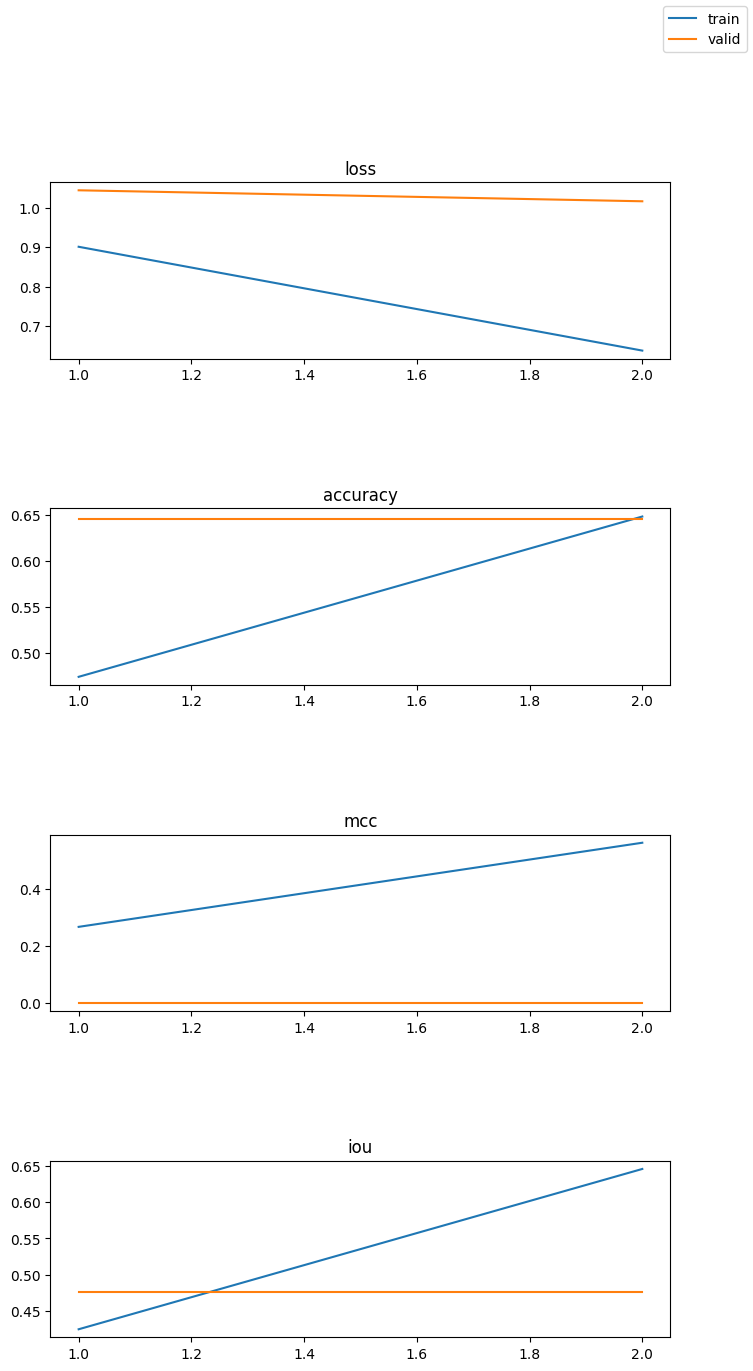

In [32]:
fig, ax = plt.subplots(4, 1, figsize=(8, 15))
ax[0].plot(np.arange(1, epochs + 1), train_loss, label='train')
ax[0].plot(np.arange(1, epochs + 1), valid_losses, label='valid')
ax[0].set_title('loss')

ax[1].plot(np.arange(1, epochs + 1), train_accuracy)
ax[1].plot(np.arange(1, epochs + 1), valid_accuracy)
ax[1].set_title('accuracy')

ax[2].plot(np.arange(1, epochs + 1), train_mcc)
ax[2].plot(np.arange(1, epochs + 1), valid_mccs)
ax[2].set_title('mcc')

ax[3].plot(np.arange(1, epochs + 1), train_iou)
ax[3].plot(np.arange(1, epochs + 1), valid_ious)
ax[3].set_title('iou')

fig.legend(loc='upper right')
plt.subplots_adjust(wspace=0., hspace=0.85)

## TEST the model

Set the model_name

In [33]:
model_name = "pointnet2_part_seg_msg" # or pointnet_part_seg
MODEL = importlib.import_module(model_name)
shutil.copy('models/%s.py' % model_name, str(exp_dir))
shutil.copy('models/pointnet2_utils.py', str(exp_dir))
normal_channel = False
model = MODEL.get_model(num_part, normal_channel=normal_channel).cuda()


MODEL_PATH = 'trained_models/' + modelname + '.pth'

model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

Set test dataloader

In [34]:
test_loader = valid_loader

In [35]:
num_test_batch = int(np.ceil(len(test_loader.dataset)/batch_size))

total_test_targets = []
total_test_preds = [] 

with torch.no_grad():

    # place model in evaluation mode
    model = model.eval()

    test_loss = []
    test_accuracy = []
    test_mcc = []
    test_iou = []
    for i, (points, targets) in enumerate(test_loader, 0):

        points = points.transpose(2, 1).to(device)
        targets = targets.squeeze().to(device)

        preds, trans_feat = model(points)
        pred_choice = torch.softmax(preds, dim=2).argmax(dim=2)

        loss =criterion(preds.contiguous().view(-1, num_part), targets.view(-1, 1)[:, 0], trans_feat) 

        # get metrics
        correct = pred_choice.eq(targets.data).cpu().sum()
        accuracy = correct/float(batch_size*npoints)
        mcc = mcc_metric(preds.transpose(2, 1), targets)
        iou = compute_iou(targets, pred_choice)

        # update epoch loss and accuracy
        test_loss.append(loss.item())
        test_accuracy.append(accuracy)
        test_mcc.append(mcc.item())
        test_iou.append(iou.item())

        # add to total targets/preds
        total_test_targets += targets.reshape(-1).cpu().numpy().tolist()
        total_test_preds += pred_choice.reshape(-1).cpu().numpy().tolist()

        if i % 50 == 0:
            print(f'\t [{i}/{num_test_batch}] ' \
                  + f'test loss: {loss.item():.4f} ' \
                  + f'accuracy: {accuracy:.4f} ' \
                  + f'mcc: {mcc:.4f} ' \
                  + f'iou: {iou:.4f}')
            
# display test results
print(f'Test Loss: {np.mean(test_loss):.4f} ' \
        + f'- Test Accuracy: {np.mean(test_accuracy):.4f} ' \
        + f'- Test MCC: {np.mean(test_mcc):.4f} ' \
        + f'- Test IOU: {np.mean(test_iou):.4f}')

Precision = metrics.precision_score(total_test_targets, total_test_preds, average='micro')

Recall = metrics.recall_score(total_test_targets, total_test_preds, average='micro' )

F1_score = metrics.f1_score(total_test_targets, total_test_preds, average='micro')
print("Precision: ", Precision, " Recall: ", Recall, " F1 score: ", F1_score)

	 [0/1] test loss: 1.0164 accuracy: 0.4036 mcc: 0.0000 iou: 0.4769
Test Loss: 1.0164 - Test Accuracy: 0.4036 - Test MCC: 0.0000 - Test IOU: 0.4769
Precision:  0.6458  Recall:  0.6458  F1 score:  0.6458


### Confusion matrix on Test data

In [36]:
total_test_targets = np.array(total_test_targets)
total_test_preds = np.array(total_test_preds)





test_confusion = pd.DataFrame(confusion_matrix(total_test_targets, total_test_preds),
                              columns=categories,
                              index=categories)

test_confusion

,leaf,stem,panice
leaf,3229,0,0
stem,692,0,0
panice,1079,0,0


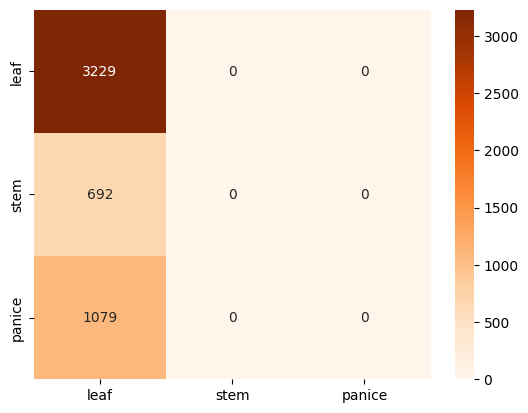

In [37]:
import seaborn as sn

#sn.set(font_scale=1.4) # for label size
#sn.color_palette("tab10")
sn.heatmap(test_confusion, cmap="Oranges", annot=True, fmt="d") # font size

plt.show()

### INFERENCE

SET testing point cloud

In [38]:
test_pointclouds = valid_pointclouds
test_pointclouds_labels = valid_pointclouds_labels

In [39]:
idx = 2
visualize_data(test_pointclouds[idx],test_pointclouds_labels[idx])

visualize_data(test_pointclouds[idx],pred_choice[idx].cpu().detach().numpy())

In [40]:
idx = 4
visualize_data(test_pointclouds[idx],test_pointclouds_labels[idx])

visualize_data(test_pointclouds[idx],pred_choice[idx].cpu().detach().numpy())